In [52]:
import pandas as pd
from biodatatools.utils.common import json_load
import seaborn as sns
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import pybedtools
import itertools
import biodataplot.genomeview as gv
import biodataplot.utils as bpu
from statannotations.Annotator import Annotator
from pathlib import Path
import sys
import numpy as np

In [53]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [54]:
sys.path.append(str(Path.cwd().parent))
import utils

In [55]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Get shape index

In [6]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [7]:
inputfile = f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt"
samples = list(pd.read_table(inputfile, header=None)[0])
len(samples)

93

In [8]:
tissues = defaultdict(list)
for s in samples:
    tissues["_".join(labels[s][1].split(" "))].append(s)
len(tissues)

15

In [56]:
bws = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_bws.json")

## Merge bws across samples for a given tissue type

In [13]:
def merge_bws(inputfiles, outputfile, k, chrom_sizes):
	commands = ["biodatatools merge_bigwig",
				"-i", " ".join(inputfiles),
				"-g", chrom_sizes,
				"-o", outputfile,
				"-autosort True",
				"-filter_chr True"
				]
	if k == "mn":
		commands.extend(["-threshold -2147483648",
						 "-remove_zero True"])
	subprocess.run(" ".join(commands), shell=True)

In [15]:
ks = ["pl", "mn"]
chrom_sizes = f"{PROJECT_DIR_r}genomes/human/hg38.chrom.sizes.filtered"

In [14]:
# Combine bw files for same tissue type

pwpool = ProcessWrapPool(10)
for t in tissues:
	for k in ks:
		inputfiles = [bws[s][ks.index(k)] for s in tissues[t]]
		outputfile = f"{PROJECT_DIR_o}temp/{t}_{k}.bw"
		pwpool.run(merge_bws, args=[inputfiles, outputfile, k, chrom_sizes])

In [51]:
len(pwpool.finished_tasks)

In [27]:
pwpool.close()

In [16]:
bws_merged = {}
for t in tissues:
    bws_merged[t] = [f"{PROJECT_DIR_o}temp/{t}_{k}.bw" for k in ks]

## Get shape index

In [18]:
# Get reads at each position

def get_pos_reads(es, bws):
	all_reads = defaultdict(dict)
	for k in ks:
		bw = pyBigWig.open(bws[ks.index(k)])
		for e in es:
			chrom, start, end = e.split("_")
			start = int(start)
			end = int(end)
			# pyBigWig: 0-based start, 0-based end; the end is not included
			if bw.intervals(chrom, start, end) != None:
				reads = {}
				for start2, end2, score in bw.intervals(chrom, start, end):
					for pos in range(max(start, start2), min(end, end2)):
						reads[pos] = abs(score)
				reads2 = [reads[pos] for pos in range(start, end) if pos in reads]
				all_reads[f"{chrom}_{start}_{end}"][k] = reads2
	return all_reads

In [19]:
# Calculate shape index for each strand

def shape_index(reads, cutoff=50):	
	if sum(reads) >= cutoff:
		SI = 2
		for i in reads:
			p = i/sum(reads)
			SI += p * np.log2(p)
	else:
		SI = np.nan
	return SI

In [20]:
# For divergent elements, we need to classify the forward and reverse peaks separately

def get_SI_matrix(es, bws, outputfile):
	all_reads = get_pos_reads(es, bws)
	results = []
	for e in all_reads:
		# at least 1 reads on both strands
		results.append([shape_index(all_reads[e][k]) for k in ks if len(all_reads[e]) == 2])
	df = pd.DataFrame(results, columns=ks, index=list(all_reads.keys()))
	# at least 50 reads on each strand
	df = df.dropna()
	df.to_csv(outputfile, sep="\t")

In [5]:
p = "divergent"
ds = ["distal", "proximal"]

In [53]:
pwpool = ProcessWrapPool(10)

for t, d in itertools.product(tissues, ds):
	outputfile = f"{PROJECT_DIR_o2}shape/{t}_{d}_SI.txt"
	df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
	es = list(df[df[tissues[t]].sum(axis=1) >= 1].index)
	pwpool.run(get_SI_matrix, args=[es, bws_merged[t], outputfile])

In [55]:
len(pwpool.finished_tasks)

30

In [56]:
pwpool.close()

# Broad (B) vs. Peaked (P)

## Classification

In [9]:
# Broad (B): SI ≤ -1.5 (Schor et al. Nat Genet. 2017)

shapes = {}
cutoff = -1.5
for t, d in itertools.product(tissues, ds):
    shapes[(t,d)] = defaultdict(set)
    inputfile = f"{PROJECT_DIR_o2}shape/{t}_{d}_SI.txt"
    df = pd.read_table(inputfile, index_col=0)
    for index, row in df.iterrows():
        if row["pl"] > cutoff and row["mn"] > cutoff:
            pt = "P-P"
        elif row["pl"] <= cutoff and row["mn"] <= cutoff:
            pt = "B-B"
        else:
            pt = "P-B"
        shapes[(t,d)][pt].add(index)

In [57]:
ptypes = ["P-P", "P-B", "B-B"]

In [ ]:
for t, d, pt in itertools.product(tissues, ds, ptypes):
    outputfile = f"{PROJECT_DIR_o2}shape/{t}_{d}_{pt}.bed"
    with DelimitedWriter(outputfile) as dw:
        for e in shapes[(t,d)][pt]:
            chrom, start, end = e.split("_")
            dw.write([chrom, start, end])
    b = pybedtools.BedTool(outputfile)
    b.sort().saveas(outputfile)

## Browser shots

In [128]:
def plot_example(region, t, title, outputfile, ylabel=True, size=500):
	region = utils.expand_genomic_pos(region, size)
	ks = ["pl", "mn"]
	data = {"PRO-cap": bws_merged[t]}
	
	formatters = {}
	height_ratios = {}
	for k in data:
		formatters[k] = {"yscale":"asym_pos_neg", "plot_kw":{"width":5}}
		height_ratios[k] = 3
	
	fig = gv.plot_genome_view(
		region,
		data = data,
		formatters = formatters,
		height_ratios = height_ratios,
		coordinate_kw = {"major_coordinate_unit":300}
		)
	
	if ylabel:
		ylabel_prop = {"fontsize":bfontsize, "rotation":90, "ha":"center"}
	else:
		ylabel_prop = {"text": ""}
	bpu.plt_change_figure_properties(
		fig,
		**{
		"fig_prop": {"size_inches":[1.4, 2]},
		"fig_suptitle": title,
		"fig_suptitle_kwargs": {"fontsize":bfontsize},
		"xticklabels_prop": {"fontsize":sfontsize},
		"yticklabels_prop": {"fontsize":sfontsize},
		"ylabel_prop": ylabel_prop,
		"xlabel_prop": {"fontsize":bfontsize}
		},
		title_prop = {"text": ""}
		)
	
	bpu.plt_change_figure_properties(
		fig, 
		ax_targets=[-1],
		xlabel_prop={"text":region.name}
		)
	
	for i in range(len(data)):
		fig.axes[i].yaxis.set_label_coords(-0.7, 0.5)
		fig.axes[i].yaxis.set_major_formatter(lambda s, pos: f"{s:.1f}")

	fig.savefig(outputfile, bbox_inches="tight", transparent=True)

In [90]:
t = "Liver"
d = "distal"
pt = "P-P"
# sorted(shapes[(t,d)][pt])
'chr12_121217172_121217461' in shapes[(t,d)][pt]

True

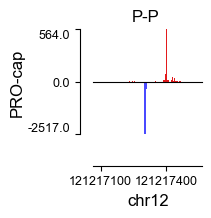

In [129]:
region = 'chr12_121217172_121217461'
chrom, start, end = region.split("_")
region = f"{chrom}:{start}-{end}"
outputfile = f"{PROJECT_DIR_o2}figures/Fig5b_1.pdf"
plot_example(region, t, "P-P", outputfile)

In [26]:
pt = "P-B"
# shapes[(t,d)][pt]
"chr15_58465189_58465350" in shapes[(t,d)][pt]

True

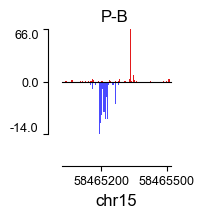

In [130]:
region = "chr15_58465189_58465350"
chrom, start, end = region.split("_")
region = f"{chrom}:{start}-{end}"
outputfile = f"{PROJECT_DIR_o2}figures/Fig5b_2.pdf"
plot_example(region, t, "P-B", outputfile, False)

In [28]:
pt = "B-B"
# shapes[(t,d)][pt]
'chr12_106120555_106120823' in shapes[(t,d)][pt]

True

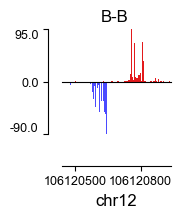

In [131]:
region = 'chr12_106120555_106120823'
chrom, start, end = region.split("_")
region = f"{chrom}:{start}-{end}"
outputfile = f"{PROJECT_DIR_o2}figures/Fig5b_3.pdf"
plot_example(region, t, "B-B", outputfile, False)

# Features

## Proportion

In [139]:
# Show proportions in each category

def plot_proportions(df_perc, shapes, ptypes, ax, outputfile):
    hue_plot_params = {"data": df_perc,
                        "x": "g3",
                        "y": "percent",
                        "hue": "g2",
                        "showfliers": False,
                        "hue_order": [d.capitalize() for d in ds],
                        "palette": ["#CBB1D1", "#CAE5C1"],
                        }
    g = sns.boxplot(ax=ax, **hue_plot_params)
    g.spines[["top", "right"]].set_visible(False)
    g.legend(title="", fontsize=sfontsize, frameon=False)
    
    g.set_xlabel("")
    g.tick_params(axis="x", labelsize=bfontsize)
    g.set_ylabel("Percent TREs (%)", fontsize=bfontsize)
    g.tick_params(axis="y", labelsize=sfontsize)
 
    fig.savefig(outputfile, bbox_inches="tight", transparent=True)

In [35]:
results = []
for t, d, pt in itertools.product(tissues, ds, ptypes):
    tot = np.sum([len(shapes[(t,d)][pt]) for pt in ptypes])
    perc = round(len(shapes[(t,d)][pt])/tot*100,1)
    results.append([t, d.capitalize(), pt, perc])
df_perc = pd.DataFrame(results, columns=["g1", "g2", "g3", "percent"])
df_perc.head(2)

,g1,g2,g3,percent
0,Blood,Distal,P-P,3.1
1,Blood,Distal,P-B,23.8


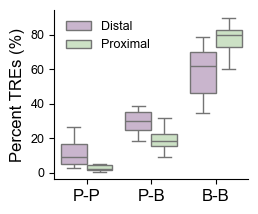

In [140]:
fig, ax = plt.subplots(figsize=(2.5,2.2))
outputfile = f"{PROJECT_DIR_o2}figures/Fig5c.pdf"
plot_proportions(df_perc, shapes, ptypes, ax, outputfile)

## Specificity scores

In [40]:
def plot_scores(t, data, ax, y, ylabel, plot_ylabel=True, yspace=-0.15, plot_legend=True, legend_pos="inside"):
    hue_plot_params = {"data": data,
                    "x": "g2",
                    "y": y,
                    "hue": "g3",
                    "hue_order": ptypes,
                    "palette": ["#80b1d3", "#bc80bd", "#fb8072"],
                    "showfliers": False
                    }
    g = sns.boxplot(ax=ax, **hue_plot_params)
    g.spines[["top", "right"]].set_visible(False)
    g.set_title(" ".join(t.split("_")), fontsize=bfontsize)

    g.set_xlabel("")
    g.tick_params(axis="x", labelsize=bfontsize)
    
    if plot_ylabel:
        g.set_ylabel(ylabel, fontsize=bfontsize)
    else:
        g.set_ylabel("")
    g.tick_params(axis="y", labelsize=sfontsize)
    g.get_yaxis().set_label_coords(yspace, 0.5)
    
    
    if plot_legend:
        if legend_pos == "inside":
            g.legend(title="", fontsize=sfontsize, frameon=False)
            
        else:
            g.legend(title="", fontsize=sfontsize, ncols=3,
                     loc="upper center", bbox_to_anchor=(0.5,1.5), frameon=False)
            
    else:
        g.legend([],[],frameon=False)
    
    pairs = []
    for d in ds:
        pairs.extend([[(d.capitalize(), "P-P"), (d.capitalize(), "P-B")], [(d.capitalize(), "P-B"), (d.capitalize(), "B-B")]])
    annotator = Annotator(g, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH", text_offset=1, text_format="star", verbose=False, line_width=lw)
    _, results = annotator.apply_and_annotate()

In [46]:
scores = {}
for d in ds:
    df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/specificity_{p}_{d}.txt", index_col=0)
    for index, row in df.iterrows():
        scores[index] = row["Specificity"]

In [48]:
results = []
shapes = defaultdict(dict)
for t, d, pt in itertools.product(tissues, ds, ptypes):
    b = pybedtools.BedTool(f"{PROJECT_DIR_o2}shape/{t}_{d}_{pt}.bed")
    shapes[(t,d)][pt] = ["_".join(i.fields[:3]) for i in b]
    for i in b:
        results.append([t, d.capitalize(), pt, scores["_".join(i.fields[:3])]])
df_scores = pd.DataFrame(results, columns=["g1", "g2", "g3", "score"])
df_scores.head(2)

,g1,g2,g3,score
0,Blood,Distal,P-P,0.601771
1,Blood,Distal,P-P,0.346835


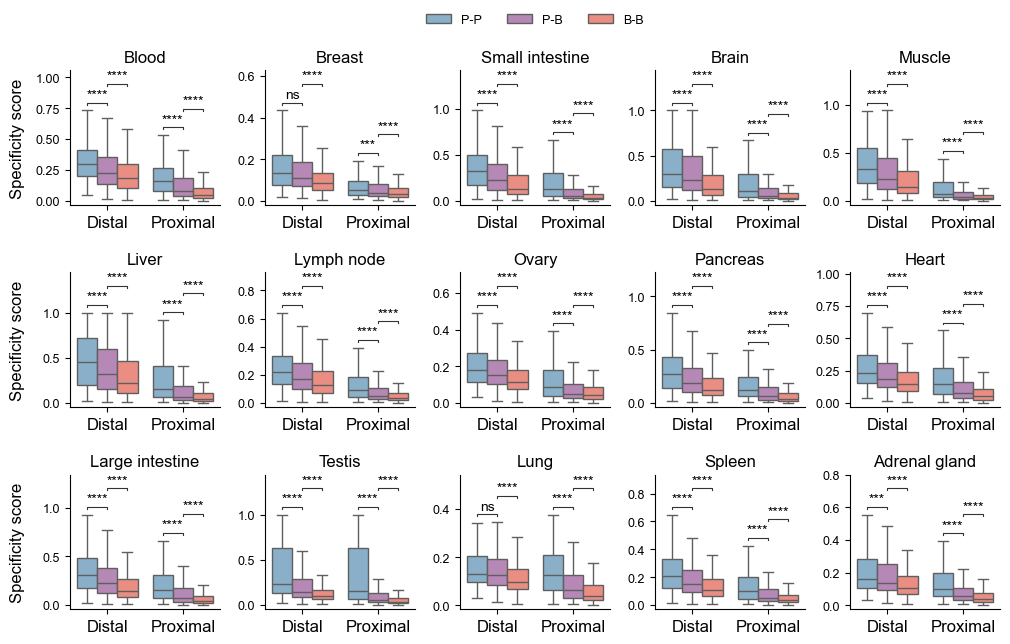

In [49]:
# Check if the pattern is consistent across tissue types

nrow = 3
ncol = 5
fig, axes = plt.subplots(nrow,ncol,figsize=(12,7))
legend_pos = "outside"
for t in tissues:
    row = list(tissues.keys()).index(t)//ncol
    col = list(tissues.keys()).index(t)%ncol
    plot_ylabel = True if col == 0 else False
    plot_legend = True if row == 0 and col == 2 else False
    plot_scores(t, df_scores[df_scores["g1"]==t], axes[row, col], "score", "Specificity score", plot_ylabel, -0.3, plot_legend, legend_pos)
fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.savefig(f"{PROJECT_DIR_o2}figures/SuppFig6.pdf", bbox_inches="tight", transparent=True)

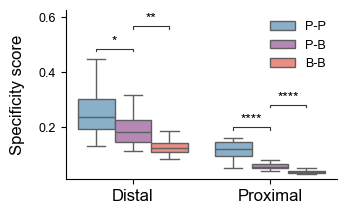

In [88]:
# Use the median value of each tissue

data = df_scores.groupby(['g1', 'g2', 'g3'])['score'].median().reset_index()
fig, ax = plt.subplots(figsize=(3.5,2.2))
plot_scores("", data, ax, "score", "Specificity score")
fig.savefig(f"{PROJECT_DIR_o2}figures/Fig5d.pdf", bbox_inches="tight", transparent=True)